# Tutorial for working with the DESI MWS VAC DR1

Here we briefly demonstrate how to use the Milky Way Survey (MWS) Value Added Catalogue (VAC) for 
DESI Data Release 1.


The data that will be used here can be downloaded from: 
https://data.desi.lbl.gov/public/dr1/vac/dr1/mws/iron

The overall description of the MWS VAC is given here:
https://data.desi.lbl.gov/doc/releases/dr1/vac/mws/

And the data-model is available here:
https://desi-mws-dr1-datamodel.readthedocs.io/

This repo has a bash file `downloader.sh` that fetches the FITS files used for this tutorial. 

In this tutorial we will use the combined file: 
* `mwsall-pix-iron.fits` which has all the MWS information for all the sources in analysed by the MWS pipelines, as well as Gaia 
DR3 cross-match and DESI targeting information.

The individual survey/program files: 
* `rvpix-main-bright.fits` -- these are the measurements by the RV pipeline of the sources in the main program, bright survey.
* `sppix-main-bright.fits` -- these are the measurements by the SP pipeline of the sources in the main program, bright survey.

Table with individual exposures measurements
* `rvpix_exp-sv3-bright.fits` -- these are the measurements by the RV pipeline from individual DESI exposures for the sv3 survey, bright program

And some individual files for stars in a given healpixel:
* `rvtab_coadd-main-bright-10813.fits` -- this a table of measurements by the RV pipeline for source in the main program, bright survey in healpixel 10813
* `rvmod_coadd-main-bright-10813.fits`

We also use one file with DESI spectra -- 
* `coadd-main-bright-10813.fits` -- From https://data.desi.lbl.gov/public/dr1/spectro/redux/iron//healpix/main/bright/108/10813/coadd-main-bright-10813.fits -- this is the file with the coadded spectra for the sources in the main program, bright survey in healpixel 10813.


###  MWS VAC DR1 paper 
The paper describing the MWS VAC (Koposov+2025 in prep) should be released shortly, but in the meantime the [EDR VAC paper]( https://ui.adsabs.harvard.edu/abs/2024MNRAS.533.1012K/abstract) should provide adequate information on the contents of the VAC.

Questions on this tutorial can be directed to Sergey Koposov (skoposov _AT_ ed _DOT_ ac _DOT_ uk)

In [1]:
import astropy.table as atpy
import astropy.coordinates as acoo
import astropy.io.fits as pyfits
import astropy.units as auni

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.colors as maco

%matplotlib inline

# Main catalogue

Here we read the combined table that most of the information. 
This table consists from several extensions that contain different information

1) RVTAB extension: RVSpecfit pipeline
2) SPTAB extension: FERRE pipeline
3) GAIA extension: Gaia parameters
4) FIBERMAP extension: table of targeting information
5) SCORES extension: spectra quality columns

Note, that when reading FITS tables with astropy tables we use `mask_invalid=False` option, due to the astropy/numpy 'peculiarities' when dealing with masked arrays.

In [2]:
# Note these are pretty big tables
RV_T = atpy.Table().read('data/mwsall-pix-iron.fits',
                         'RVTAB',
                         mask_invalid=False)
SP_T = atpy.Table().read('data/mwsall-pix-iron.fits',
                         'SPTAB',
                         mask_invalid=False)
FM_T = atpy.Table().read('data/mwsall-pix-iron.fits',
                         'FIBERMAP',
                         mask_invalid=False)
SC_T = atpy.Table().read('data/mwsall-pix-iron.fits',
                         'SCORES',
                         mask_invalid=False)

# Reading the Gaia cross-match table 

Since the Gaia cross-match table has all the Gaia columns, 
you may run out of memory if reading as an astropy table, so we read as a FITS table. 

In [3]:
# G_T = atpy.Table().read('data/mwsall-pix-iron.fits',
#                        'GAIA',
#                        mask_invalid=False)
G_T = pyfits.getdata('data/mwsall-pix-iron.fits', 'GAIA')

# Selecting sources
Here we identify the subset of sources that are 

1) primary (i.e. the best observation if the object was observed in more than one survey/program
2) have no RVS warning flags
3) are classified as star by Redrock

In [4]:
main_sel = RV_T['PRIMARY'] & (RV_T['RVS_WARN'] == 0) & (RV_T['RR_SPECTYPE']
                                                        == 'STAR')

# Sky distribution

Text(0, 0.5, 'dec [deg]')

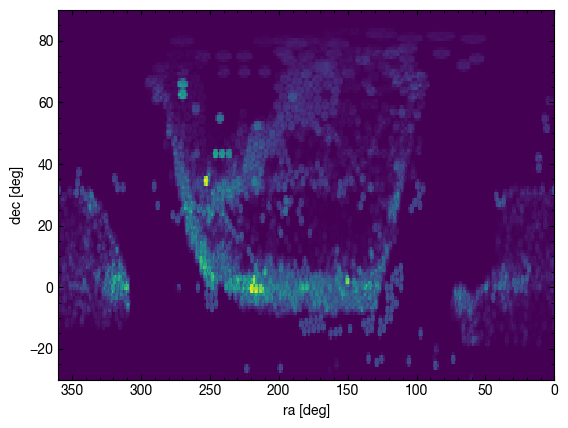

In [5]:
plt.hist2d(RV_T['TARGET_RA'][main_sel],
           RV_T['TARGET_DEC'][main_sel],
           bins=[360, 120],
           range=[[0, 360], [-30, 90]])
plt.xlabel('ra [deg]')
plt.xlim(360, 0)
plt.ylabel('dec [deg]')

# Multiple surveys/programs

The catalogue consists measurements from multiple DESI surveys/programs.

The survey with the most stars is `main`. This survey has three programs `bright` (with the most stars and where the Milky Survey is being executed), `dark` and `backup`. 

In [6]:
# Colour-magnitude distribution by survey/program
print('surveys', np.unique(RV_T['SURVEY'][:]))
print('program', np.unique(RV_T['PROGRAM'][:]))

surveys  SURVEY
-------
    cmx
   main
special
    sv1
    sv2
    sv3
program PROGRAM
-------
 backup
 bright
   dark
  other


# Spatial distribution of objects in different surveys, programs

Here we look at several programs, surveys and look at spatial distribution of targets there


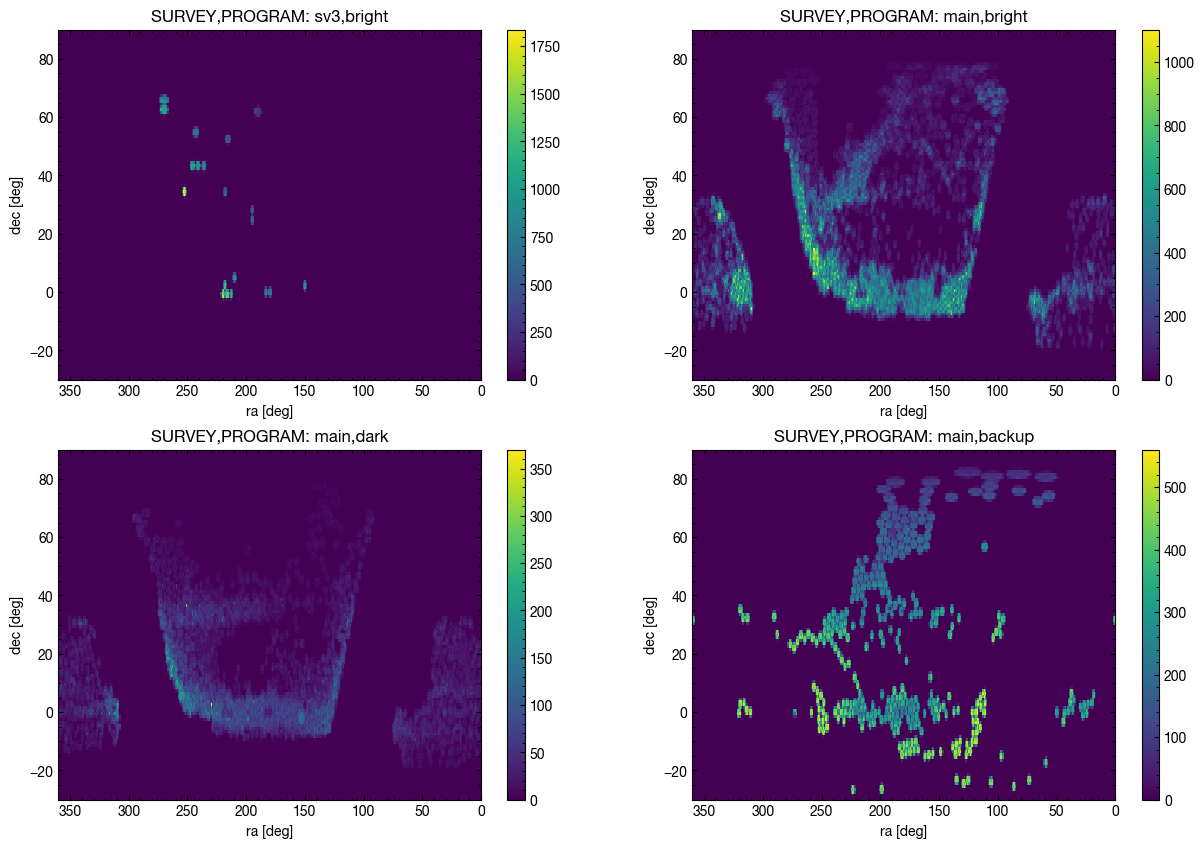

In [7]:
plt.figure(1, figsize=(15, 10))
cnt = 0
for survey, program in [('sv3', 'bright'), ('main', 'bright'),
                        ('main', 'dark'), ('main', 'backup')]:
    cur_sel = main_sel & (RV_T['SURVEY'] == survey) & (RV_T['PROGRAM']
                                                       == program)
    plt.subplot(2, 2, cnt + 1)
    plt.hist2d(RV_T['TARGET_RA'][cur_sel],
               RV_T['TARGET_DEC'][cur_sel],
               bins=[360, 120],
               range=[[0, 360], [-30, 90]])
    cnt += 1
    plt.title(f'SURVEY,PROGRAM: {survey},{program}')
    plt.xlabel('ra [deg]')
    plt.xlim(360, 0)
    plt.ylabel('dec [deg]')
    plt.colorbar()


# Photometry, targeting information

So far we mostly used the RVTAB extension, which has some basic source information as well 
as radial velocity and stellar parameters info from RV pipeline. 

If you need photometry and/or targeting information, it is mostly in the FIBERMAP extension.

Note that backup program of the main survey was *not* targeted using DESI/DECaLS(legacy) survey, 
therefore it does not have the DECALS flux columns populated. 
For all the rest we can use the FLUX_G, FLUX_R, FLUX_Z sources which are fluxes in g, r, z filters in 
nano-maggies (so they can b converted to magnitudes using 22.5-2.5*log10(flux))

You can see a description of columns in that extension here 
https://desi-mws-dr1-datamodel.readthedocs.io/en/latest/mwsall.html#hdu3


The columns in the fibermap extension:
<TableColumns names=('TARGETID','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','FA_TARGET','FA_TYPE','OBJTYPE','SUBPRIORITY','OBSCONDITIONS','RELEASE','BRICKNAME','BRICKID','BRICK_OBJID','MORPHTYPE','EBV','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','FLUX_IVAR_W1','FLUX_IVAR_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','MASKBITS','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','PHOTSYS','PRIORITY_INIT','NUMOBS_INIT','CMX_TARGET','DESI_TARGET','BGS_TARGET','MWS_TARGET','PLATE_RA','PLATE_DEC','COADD_NUMEXP','COADD_EXPTIME','COADD_NUMNIGHT','COADD_NUMTILE','MEAN_DELTA_X','RMS_DELTA_X','MEAN_DELTA_Y','RMS_DELTA_Y','MEAN_FIBER_RA','STD_FIBER_RA','MEAN_FIBER_DEC','STD_FIBER_DEC','MEAN_PSF_TO_FIBER_SPECFLUX','SCND_TARGET','SV1_DESI_TARGET','SV

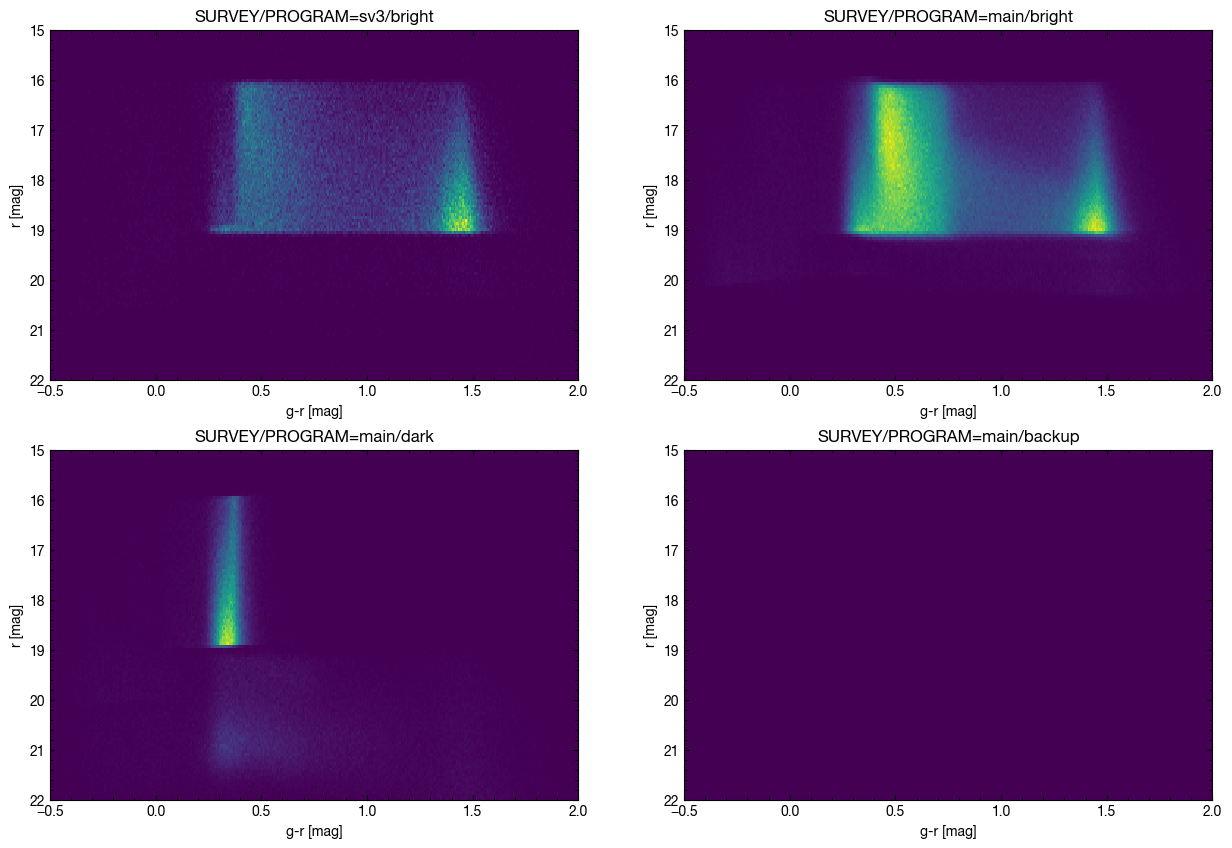

In [8]:
print('The columns in the fibermap extension:')
print((FM_T.columns))
print('----')
np.seterr(divide='ignore', invalid='ignore')
plt.figure(1, figsize=(15, 10))
cnt = 0
for survey, program in [('sv3', 'bright'), ('main', 'bright'),
                        ('main', 'dark'), ('main', 'backup')]:
    cur_sel = main_sel & (RV_T['SURVEY'] == survey) & (RV_T['PROGRAM']
                                                       == program)
    plt.subplot(2, 2, cnt + 1)
    plt.hist2d(-2.5 *
               np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),
               22.5 - 2.5 * np.log10(FM_T['FLUX_R'][cur_sel]),
               bins=[360, 120],
               range=[[-0.5, 2], [15, 22]])
    cnt += 1
    plt.title(f'SURVEY/PROGRAM={survey}/{program}')
    plt.xlabel('g-r [mag]')
    plt.ylim(22, 15)
    plt.ylabel('r [mag]')

# The colour magnitude distribution for backup survey

As mentioned above. The backup survey was targeted using Gaia photometry, and sources there are often brighter than the DECaLS saturation, as well as extend further than the DECaLS footprint. 
Therefore, it makes sense to look at backup program sources using Gaia magnitudes.

Gaia magnitudes are stored in the GAIA extension of the table. 

Note: that although there are Gaia magnitudes in the FIBERMAP extension as well, you should use the GAIA extension for the Gaia DR3 magnitudes.

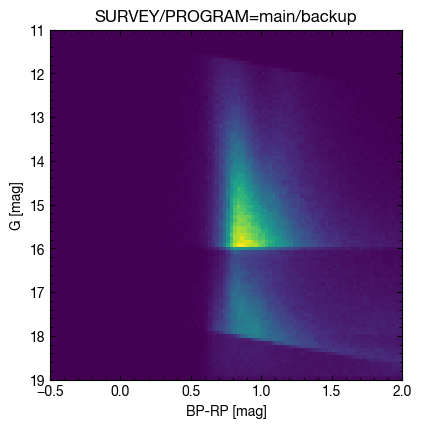

In [9]:
plt.figure(1, figsize=(10, 10))
cnt = 0
for survey, program in [('main', 'backup')]:
    cur_sel = main_sel & (RV_T['SURVEY'] == survey) & (RV_T['PROGRAM']
                                                       == program)
    plt.subplot(2, 2, cnt + 1)
    plt.hist2d(G_T['PHOT_BP_MEAN_MAG'][cur_sel] -
               G_T['PHOT_RP_MEAN_MAG'][cur_sel],
               G_T['PHOT_G_MEAN_MAG'][cur_sel],
               bins=[100, 100],
               range=[[-0.5, 2], [11, 19]])
    cnt += 1
    plt.title(f'SURVEY/PROGRAM={survey}/{program}')
    plt.xlabel('BP-RP [mag]')
    plt.ylim(19, 11)
    plt.ylabel('G [mag]')

# Different types of targets 

The targeting information is contained in the DESI_TARGET, MWS_TARGET, BGS_TARGET, SCND_TARGET columns that are bitmasks

The detailed information about those  is elsewhere, but here we show the main MWS object types
(see 
https://github.com/desihub/desitarget/blob/main/py/desitarget/data/targetmask.yaml
also, Koposov et al. 2024, Cooper et al. 2023, Myers et al. 2023)


    - [MWS_BROAD,           0, "Milky Way Survey magnitude limited bulk sample",         {obsconditions: BRIGHT}]
    - [MWS_WD,              1, "Milky Way Survey White Dwarf",                           {obsconditions: BRIGHT|DARK}]
    - [MWS_NEARBY,          2, "Milky Way Survey volume-complete ~100pc sample",         {obsconditions: BRIGHT}]
    # MWS BHBs
    - [MWS_BHB,             6, "Milky Way Survey Blue Horizontal Branch stars", {obsconditions: BRIGHT|DARK}]

    # Sub-classes of MWS_MAIN
    - [MWS_MAIN_BLUE,       8, "Milky Way Survey magnitude limited blue sample",              {obsconditions: BRIGHT}]
    - [MWS_MAIN_RED,        11, "Milky Way Survey magnitude limited red sample",              {obsconditions: BRIGHT}]

    # Standard stars based only on Gaia.
    - [GAIA_STD_FAINT,      33, "Standard stars for dark/gray conditions",   {obsconditions: DARK|BACKUP|TWILIGHT12|TWILIGHT18}]
    - [GAIA_STD_WD,         34, "White Dwarf stars",                         {obsconditions: DARK|BRIGHT|BACKUP|TWILIGHT12|TWILIGHT18}]
    - [GAIA_STD_BRIGHT,     35, "Standard stars for BRIGHT conditions",      {obsconditions: BRIGHT|BACKUP|TWILIGHT12|TWILIGHT18}]

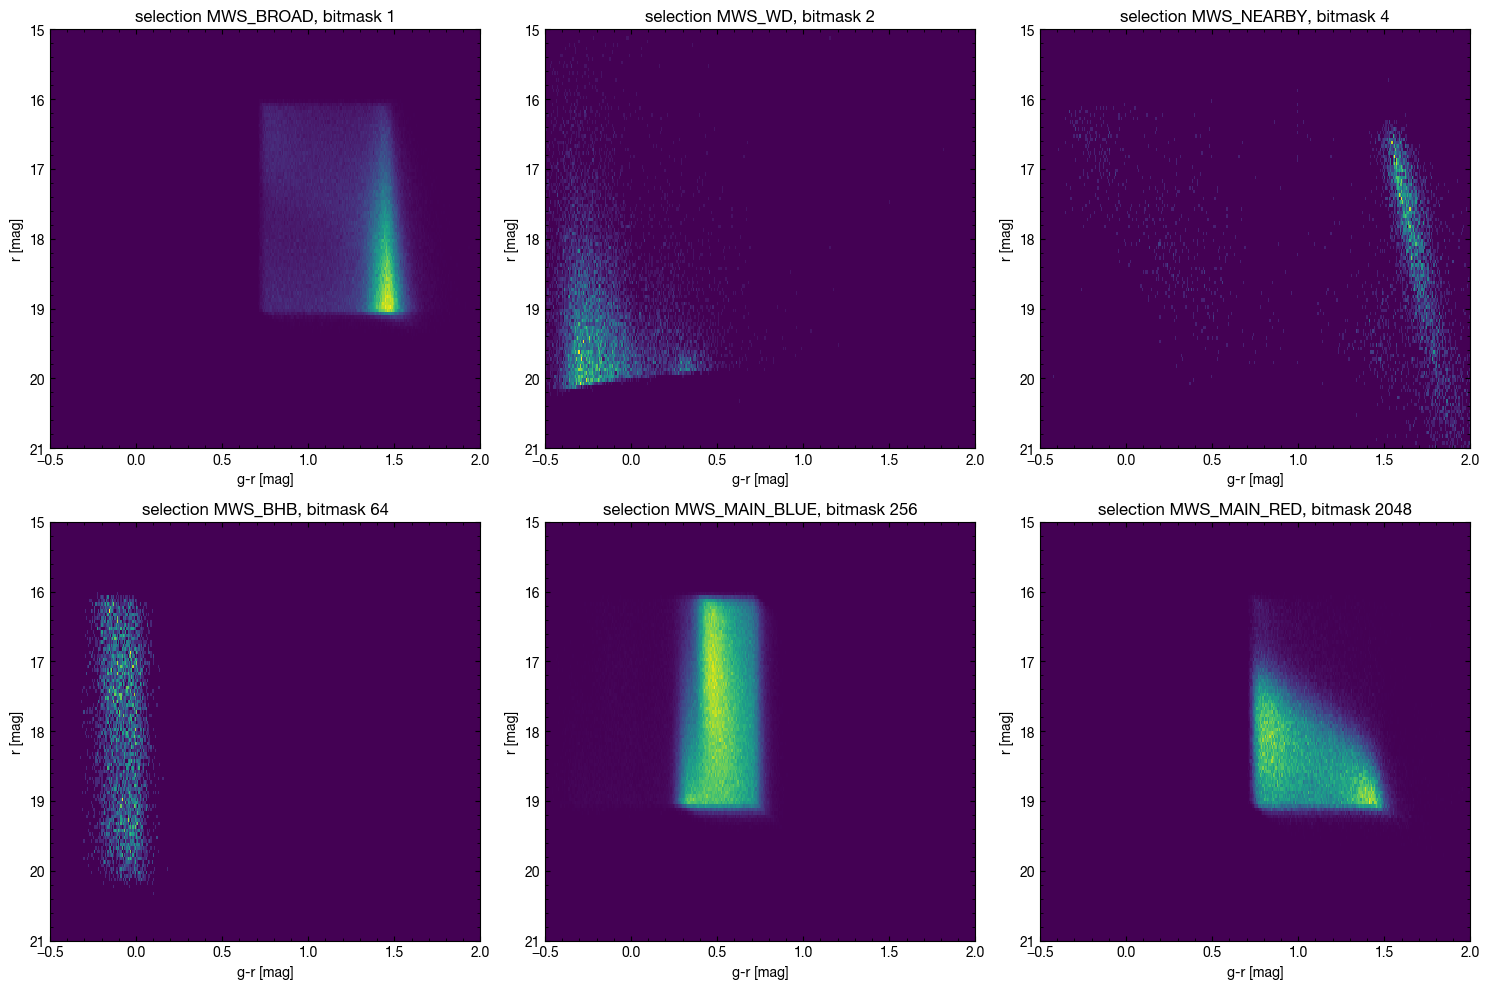

In [10]:
plt.figure(1, figsize=(15, 10))
cnt = 0
bitmasks = {
    'MWS_BROAD': 0,
    'MWS_WD': 1,
    'MWS_NEARBY': 2,
    'MWS_BHB': 6,
    'MWS_MAIN_BLUE': 8,
    'MWS_MAIN_RED': 11
}
survey, program = ('main', 'bright')

for curt, bit in bitmasks.items():
    objtype_sel = (FM_T['MWS_TARGET'] & (2**bit)) > 0
    cur_sel = objtype_sel & main_sel & (RV_T['SURVEY'] == survey) & (
        RV_T['PROGRAM'] == program)
    plt.subplot(2, 3, cnt + 1)
    plt.hist2d(-2.5 *
               np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),
               22.5 - 2.5 * np.log10(FM_T['FLUX_R'][cur_sel]),
               bins=[360, 120],
               range=[[-0.5, 2], [15, 21]])
    cnt += 1
    plt.title(f'selection {curt}, bitmask {2**bit}')
    plt.xlabel('g-r [mag]')
    plt.ylim(21, 15)
    plt.ylabel('r [mag]')
plt.tight_layout()

# Stellar parameters

Here we look at surface gravity and effective temperature for stars the main/bright survey. 
We select signal-to-noise higher than 10 in the R arm.

Here we also look at parameters from both pipelines SP and RV

We also apply a VSINI<30 cut when using RV parameters 
and apply BESTGRID!='s_rdesi1 selection when using the SP parameters 

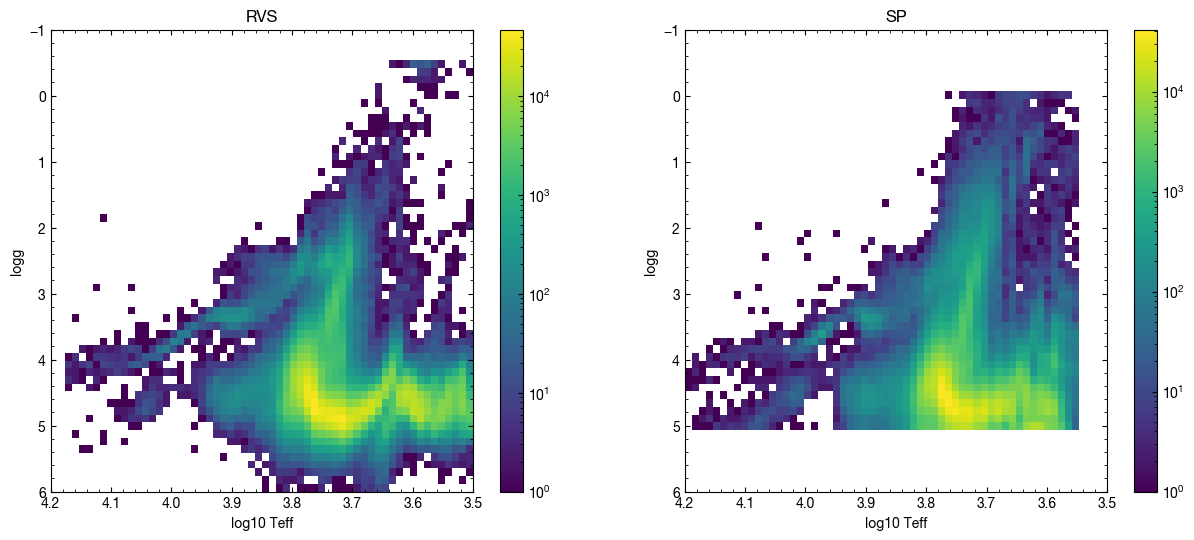

In [11]:
cur_sel = main_sel & (RV_T['SURVEY'] == 'main') & (
    RV_T['PROGRAM'] == 'bright') & (RV_T['SN_R'] > 10) & (RV_T['VSINI'] < 30)
plt.figure(1, figsize=(15, 6))
plt.subplot(121)
plt.hist2d(np.log10(RV_T['TEFF'][cur_sel]),
           RV_T['LOGG'][cur_sel],
           range=[[3.5, 4.2], [-1, 6]],
           bins=[60, 60],
           norm=maco.LogNorm())
plt.xlim(4.2, 3.5)
plt.ylim(6, -1)
plt.xlabel('log10 Teff')
plt.ylabel('logg')
plt.title('RVS')
plt.colorbar()

plt.subplot(122)
cur_sel = main_sel & (RV_T['SURVEY'] == 'main') & (
    RV_T['PROGRAM'] == 'bright') & (SP_T['SUCCESS'] == 1) & (SP_T['BESTGRID']
                                                             != 's_rdesi1')
plt.hist2d(np.log10(SP_T['TEFF'][cur_sel]),
           SP_T['LOGG'][cur_sel],
           range=[[3.5, 4.2], [-1, 6]],
           bins=[60, 60],
           norm=maco.LogNorm())
plt.xlim(4.2, 3.5)
plt.ylim(6, -1)
plt.xlabel('log10 Teff')
plt.ylabel('logg')
plt.title('SP')
plt.colorbar()

# Abundances 

[Fe/H] vs [a/Fe] distribution for RV and SP pipelines

We apply similar cuts as before and select stars with effective temperature between 4500 and 7000 K

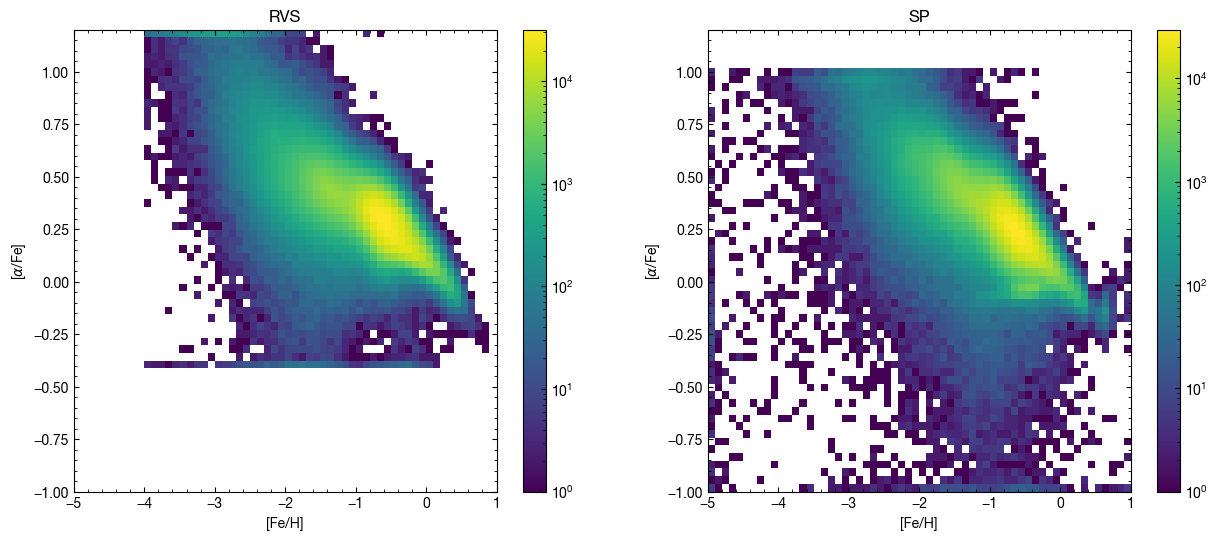

In [12]:
min_teff = 4500
max_teff = 7000

cur_sel = (main_sel & (RV_T['SURVEY'] == 'main') &
           (RV_T['PROGRAM'] == 'bright') & (RV_T['VSINI'] < 30) &
           (RV_T['TEFF'] > min_teff) & (RV_T['TEFF'] < max_teff) &
           (RV_T['SN_R'] > 10))
plt.figure(1, figsize=(15, 6))
plt.subplot(121)
plt.hist2d(RV_T['FEH'][cur_sel],
           RV_T['ALPHAFE'][cur_sel],
           range=[[-5, 1], [-1, 1.2]],
           bins=[60, 60],
           norm=maco.LogNorm())
plt.xlabel('[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.title('RVS')
plt.colorbar()

plt.subplot(122)
cur_sel = main_sel & (RV_T['SURVEY'] == 'main') & (
    RV_T['PROGRAM'] == 'bright') & (RV_T['SN_R'] > 10) & (
        SP_T['SUCCESS'] == 1) & (SP_T['BESTGRID'] != 's_rdesi1')
plt.hist2d(SP_T['FEH'][cur_sel],
           SP_T['ALPHAFE'][cur_sel],
           range=[[-5, 1], [-1, 1.2]],
           bins=[60, 60],
           norm=maco.LogNorm())
plt.xlabel('[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.title('SP')
plt.colorbar()

# Metallicity distribution

Here we show the distribution of iron abundances in the main survey 
as measured by two stellar pipelines RV and SP.

We also restrict the sample by the effective temperature from 4500 to 7000 K and SNR>10 in the R arm.

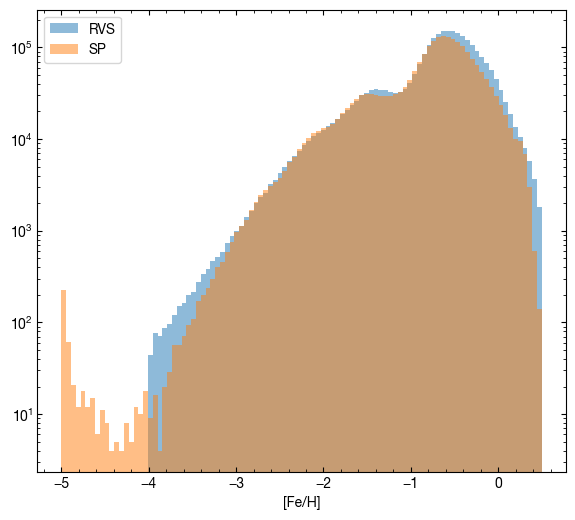

In [13]:
min_teff = 4500
max_teff = 7000
cur_sel = (main_sel & (RV_T['SURVEY'] == 'main') & (RV_T['SN_R'] > 10) &
           (RV_T['TEFF'] > min_teff) & (RV_T['TEFF'] < max_teff) &
           (RV_T['VSINI'] < 30))

plt.figure(1, figsize=(15, 6))
plt.subplot(121)
plt.hist(RV_T['FEH'][cur_sel], range=[-5, .5], label='RVS', alpha=.5, bins=100)
plt.xlabel('[Fe/H]')
cur_sel = (main_sel & (RV_T['SURVEY'] == 'main') & (RV_T['SN_R'] > 10) &
           (SP_T['BESTGRID'] != 's_rdesi1') & (SP_T['TEFF'] > min_teff) &
           (SP_T['TEFF'] < max_teff))
plt.hist(SP_T['FEH'][cur_sel], range=[-5, .5], label='SP', alpha=.5, bins=100)
plt.gca().set_yscale('log')
plt.legend()

# Chemo-dynamics with DESI

Here we just make some basic plots using distance from Gaia parallaxes.

We note that for the DR1, the spectro-photometric distances for all the stellar sources have been computed and are available as two VACs.
See https://data.desi.lbl.gov/doc/releases/dr1/vac/

In [14]:
dist = 1. / G_T['PARALLAX']
dist[(dist < 0)] = np.nan
C = acoo.SkyCoord(ra=RV_T['TARGET_RA'] * auni.deg,
                  dec=RV_T['TARGET_DEC'] * auni.deg,
                  distance=dist * auni.kpc,
                  pm_ra_cosdec=G_T['PMRA'] * auni.mas / auni.year,
                  pm_dec=G_T['PMDEC'] * auni.mas / auni.year,
                  radial_velocity=RV_T['VRAD'])
Cg = C.transform_to(acoo.Galactocentric)
Cs = Cg.represent_as(acoo.SphericalRepresentation)
Cc = Cg.represent_as(acoo.CylindricalRepresentation)
Vphi = (Cc.differentials['s'].d_phi * Cc.rho / auni.rad).to_value(auni.km /
                                                                  auni.s)
Vpsi = (Cs.differentials['s'].d_lat * Cc.rho / auni.rad).to_value(auni.km /
                                                                  auni.s)
VR = Cs.differentials['s'].d_distance.to_value(auni.km / auni.s)
R = Cs.distance.to_value(auni.kpc)
LZ = (Vphi * Cc.rho).to_value(auni.kpc)

# Gaia phase-space spiral

Here we just reproduce the Gaia phase-space spiral from Antoja+2021 for the MWS sources with [Fe/H]>-0.2 in the VAC.

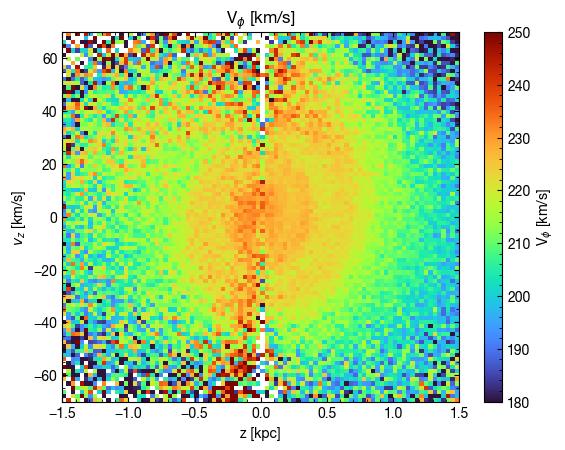

In [15]:
cur_sel = main_sel & (G_T['PARALLAX']
                      > 4 * G_T['PARALLAX_ERROR']) & (RV_T['FEH'] > -0.3)
S = scipy.stats.binned_statistic_2d(Cg.z[cur_sel],
                                    Cg.v_z[cur_sel],
                                    Vphi[cur_sel],
                                    'median',
                                    range=[[-1.5, 1.5], [-70, 70]],
                                    bins=[90, 90])

plt.imshow(-S.statistic.T,
           extent=(-1.5, 1.5, -70, 70),
           origin='lower',
           cmap='turbo',
           aspect='auto',
           vmin=180,
           vmax=250)

plt.xlabel('z [kpc]')
plt.ylabel(r'$v_z$ [km/s]')
plt.title(r'V$_\phi$ [km/s]')
plt.colorbar(label=r'V$_\phi$ [km/s]')

# Gaia-Encelladus-Sausage

Here we plot VR vs Vphi in the solar-neighbourhood to show the radially biased orbits from the GSE for the metallicity range around [Fe/H]=-1.2,
the isotropic stellar halo at lower metallicities and, mostly disc + Splash at higher metallicities

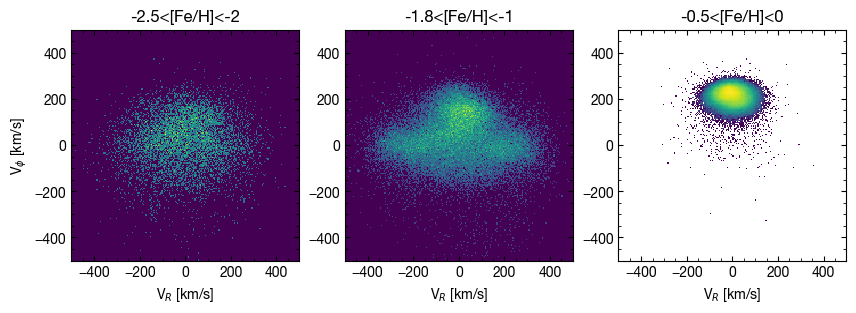

In [16]:
cur_sel0 = (main_sel & (G_T['PARALLAX'] > 5 * G_T['PARALLAX_ERROR']) &
            (RV_T['TEFF'] > 4500) & (RV_T['TEFF'] < 7000) &
            (RV_T['VSINI'] < 30))
cur_sel = cur_sel0 & (RV_T['FEH'] > -2.5) & (RV_T['FEH'] < -2)

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.hist2d(VR[cur_sel],
           -Vphi[cur_sel],
           range=[[-500, 500], [-500, 500]],
           bins=[200, 200],
           norm=maco.PowerNorm(gamma=.5))
plt.title('-2.5<[Fe/H]<-2')
plt.xlabel('V$_R$ [km/s]')
plt.ylabel(r'V$_\phi$ [km/s]')

cur_sel = cur_sel0 & (RV_T['FEH'] > -1.8) & (RV_T['FEH'] < -1.2)

plt.subplot(1, 3, 2)
plt.hist2d(VR[cur_sel],
           -Vphi[cur_sel],
           range=[[-500, 500], [-500, 500]],
           bins=[200, 200],
           norm=maco.PowerNorm(gamma=.5))
plt.title('-1.8<[Fe/H]<-1')
plt.xlabel('V$_R$ [km/s]')

cur_sel = cur_sel0 & (RV_T['FEH'] > -0.2) & (RV_T['FEH'] < -0)

plt.subplot(1, 3, 3)
plt.hist2d(VR[cur_sel],
           -Vphi[cur_sel],
           range=[[-500, 500], [-500, 500]],
           bins=[200, 200],
           norm=maco.LogNorm())
plt.title('-0.5<[Fe/H]<0')
plt.xlabel('V$_R$ [km/s]');


# Single epoch data

Here we look at the single epoch measurements just in the one survey/program sv3/bright

In [17]:
T_RV1 = atpy.Table().read('data/rvpix_exp-sv3-bright.fits',
                          'RVTAB',
                          mask_invalid=False)
T_FM1 = atpy.Table().read('data/rvpix_exp-sv3-bright.fits',
                          'FIBERMAP',
                          mask_invalid=False)
T_G1 = atpy.Table().read('data/rvpix_exp-sv3-bright.fits',
                         "GAIA",
                         mask_invalid=False)

Now we just look at one object with source_id=3698465917056207872 that is an RR Lyrae star. 
We show its radial velocity curve from DESI (from just sv3/bright) and show it after folding with the Gaia DR3 period

(0.0, 2.0)

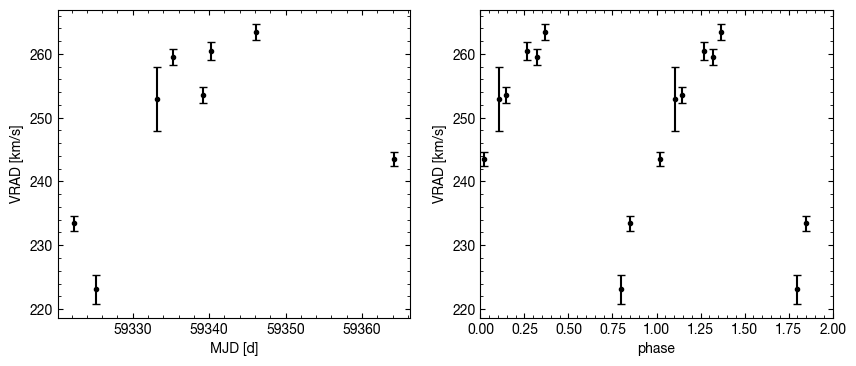

In [18]:
rrl = T_G1['SOURCE_ID'] == 3698465917056207872
rrl.sum()
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.errorbar(T_FM1['MJD'][rrl],
             T_RV1['VRAD'][rrl],
             T_RV1['VRAD_ERR'][rrl],
             fmt='k.')
plt.xlabel('MJD [d]')
plt.ylabel('VRAD [km/s]')
period = 0.49197089  # from Gaia DR3

plt.subplot(1, 2, 2)
plt.errorbar((T_FM1['MJD'][rrl] % period) / period,
             T_RV1['VRAD'][rrl],
             T_RV1['VRAD_ERR'][rrl],
             fmt='k.')
plt.errorbar((T_FM1['MJD'][rrl] % period) / period + 1,
             T_RV1['VRAD'][rrl],
             T_RV1['VRAD_ERR'][rrl],
             fmt='k.')
plt.xlabel('phase')
plt.ylabel('VRAD [km/s]')
plt.xlim(0, 2)

# Spectrum models 

Here we look at the spectral models from the RVS pipeline for one star and compare them to the observed spectra.
The model spectra are in the rvmod files. The rvmod files have the same number of rows as the rvtab files, and they are in the same order.
Importantly however, the rvtab file may have fewer rows than the original DESI file with spectra `coadd-....fits` file, because the RV pipeline does not fit *every* source observed by DESI.

In [19]:
# reading the desi coadded spectra for healpix 10813
SP = pyfits.open('data/coadd-main-bright-10813.fits')

# Reading the rv table and the rvspecfit models
RV_T2 = atpy.Table().read('data/rvtab_coadd-main-bright-10813.fits', 'RVTAB')
RVM = pyfits.open('data/rvmod_coadd-main-bright-10813.fits')

# Here are the TARGETIDs of observed objects in this healpix
print(RV_T2['TARGETID'])


     TARGETID    
-----------------
39633072399846816
39633072404038155
39633077051326547
39633072399847356
39633081686033429
 2781849965297671
39633081681838945
39633081681839446
39633077055521407
39633077051329327
              ...
39633086291379669
39633086291379507
39633081673451811
39633081673453230
 2781849956909069
39633081673452595
 2781849956909063
39633081677644832
39633081681838460
39633081681839316
Length = 51 rows


Now we just pick up one object with TARGETID 39633086291379507 and show the observed spectra and the model spectra from the RVS pipeline.

Text(0, 0.5, 'Flux [1e-17 erg/s/cm^2/A]')

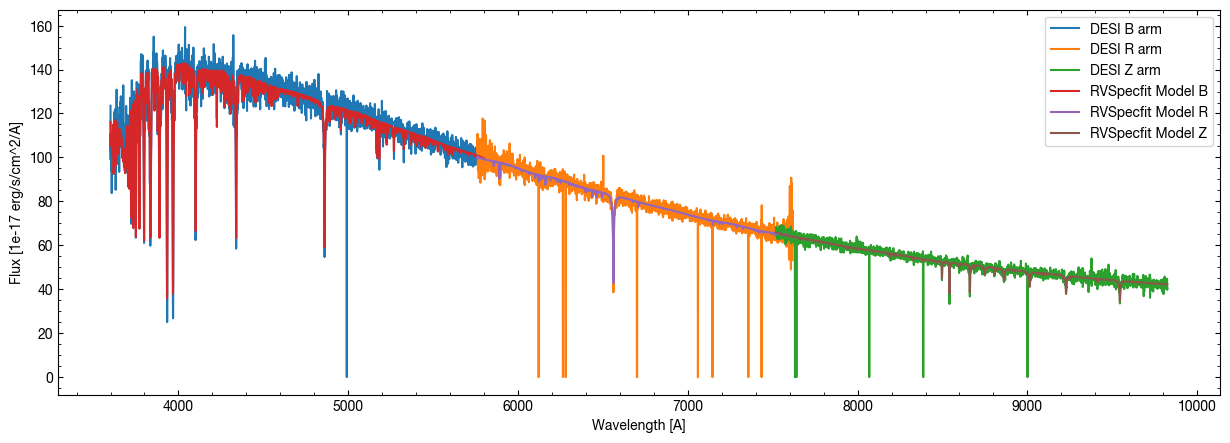

In [20]:
targetid = 39633086291379507
sel = SP['FIBERMAP'].data['TARGETID'] == targetid
rv_sel = RV_T2['TARGETID'] == targetid

plt.figure(figsize=(15, 5))
plt.plot(SP['B_WAVELENGTH'].data,
         SP['B_FLUX'].data[sel][0],
         label='DESI B arm')
plt.plot(SP['R_WAVELENGTH'].data,
         SP['R_FLUX'].data[sel][0],
         label='DESI R arm')
plt.plot(SP['Z_WAVELENGTH'].data,
         SP['Z_FLUX'].data[sel][0],
         label='DESI Z arm')
plt.plot(RVM['B_WAVELENGTH'].data,
         RVM['B_MODEL'].data[rv_sel][0],
         label='RVSpecfit Model B')
plt.plot(RVM['R_WAVELENGTH'].data,
         RVM['R_MODEL'].data[rv_sel][0],
         label='RVSpecfit Model R')
plt.plot(RVM['Z_WAVELENGTH'].data,
         RVM['Z_MODEL'].data[rv_sel][0],
         label='RVSpecfit Model Z')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux [1e-17 erg/s/cm^2/A]')